<a href="https://colab.research.google.com/github/John-Ragland/ee511_assignments/blob/main/project/final_project_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup the Notebook and Get Data<a name="set-up"></a>

In [1]:
# Suppress Warnings
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
import torch
import torch.nn as nn 
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import KFold

In [2]:
# look_back = 3 # games
def get_data(data_type, start_year, end_year=2019, week=None):
    website = 'https://api.collegefootballdata.com/' + data_type
    frames = []
    for year in range(start_year, end_year+1):
        url = website + '?year=%d' % year
        if week:
          # start = max(week - look_back, 1)
          # url += '&startWeek=%d' % start
          url += '&endWeek=%d' % week
        frames.append(pd.read_json(url))
    return pd.concat(frames)

In [3]:
def get_weekly_stats(start_year):
  frames = []
  for week in range(1, 16):
    week_frame = get_data('stats/season', start_year, week=week)
    week_frame['week'] = week+1
    frames.append(week_frame)
  return pd.concat(frames)

In [4]:
# collect the data
begin = 2004
original_stats = get_weekly_stats(begin)
original_games = get_data('games', begin)
original_teams = pd.read_json('https://api.collegefootballdata.com/teams')
original_spread = get_data('metrics/wp/pregame', 2013)
original_rankings = get_data('rankings', begin)

In [5]:
# get the games and calculate spread (result)
games = original_games
games = games.assign(result = (games.home_points-games.away_points))
games = games.loc[:, games.columns.intersection(['id', 'season', 'week', 'home_team', 'away_team', 'result', 'excitement_index'])]

# add pregame predictions
spreads = original_spread.loc[:, original_spread.columns.intersection(['gameId', 'spread', 'homeWinProb'])]
spreads.spread *= -1
games = pd.merge(games, spreads, how='left', left_on=['id'], right_on=['gameId']).drop(['gameId'], axis=1)

# get the list of stats
stats = original_stats
stats = stats.drop(columns=['conference'])
w = stats.loc[(stats.team == 'Washington') & (stats.season == begin)]
stat_cols = w.statName.to_list()
stat_cols = list(set(stat_cols)) # remove duplicates
stat_cols.sort()
stat_cols.remove('games')
print(stat_cols)

# add each stat of both teams
s = stats.loc[(stats.statName == 'games')]
s = s.drop(columns=['statName'])
games = pd.merge(games, s.rename(columns={'statValue': 'home_games'}), how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
games = pd.merge(games, s.rename(columns={'statValue': 'away_games'}), how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)

for stat in stat_cols:
  s = stats.loc[(stats.statName == stat)]
  s = s.drop(columns=['statName'])
  games = pd.merge(games, s.rename(columns={'statValue': 'home_'+stat}), how='left', left_on=['season', 'home_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
  games = pd.merge(games, s.rename(columns={'statValue': 'away_'+stat}), how='left', left_on=['season', 'away_team', 'week'], right_on=['season', 'team', 'week']).drop(['team'], axis=1)
  games = games.fillna(0)
  games[stat] = (games['home_'+stat]/games.home_games) - (games['away_'+stat]/games.away_games)
  games = games.drop(columns=['home_'+stat, 'away_'+stat])

games = games.fillna(0)

['firstDowns', 'fourthDownConversions', 'fourthDowns', 'fumblesLost', 'fumblesRecovered', 'interceptionTDs', 'interceptionYards', 'interceptions', 'netPassingYards', 'passAttempts', 'passCompletions', 'passesIntercepted', 'passingTDs', 'penalties', 'penaltyYards', 'possessionTime', 'puntReturnTDs', 'puntReturnYards', 'puntReturns', 'rushingAttempts', 'rushingTDs', 'rushingYards', 'thirdDownConversions', 'thirdDowns', 'totalYards', 'turnovers']


In [6]:
# create the table for total points a team scored for and against before a given week
points_per_game = original_teams.loc[:, original_teams.columns.intersection(['school'])]
points_per_game['year'] = 2020
one_season = points_per_game.copy()
for year in range(2004, 2020):
  temp = one_season.copy()
  temp['year'] = year
  points_per_game = pd.concat([points_per_game, temp], ignore_index=True)

points_per_game[('points_for_week1')] = 0.0
points_per_game[('points_against_week1')] = 0.0
scores = original_games.loc[:, original_games.columns.intersection(['season', 'week', 'home_team', 'away_team', 'home_points', 'away_points'])]
scores['week'] += 1
for week in range(2, 16):
  this_scores = scores.loc[scores.week == week]
  this_scores = this_scores.rename(columns={'home_points': ('points_for_week%d' % week), 'away_points': ('points_against_week%d' % week)})
  points_per_game = pd.merge(points_per_game, this_scores, how='left', left_on=['school', 'year'], right_on=['home_team', 'season']).drop(['home_team', 'away_team', 'season', 'week'], axis=1)
  this_scores = scores.loc[scores.week == week]
  this_scores = this_scores.rename(columns={'away_points': ('points_for_week%d' % week), 'home_points': ('points_against_week%d' % week)})
  points_per_game = pd.merge(points_per_game, this_scores, how='left', left_on=['school', 'year'], right_on=['away_team', 'season']).drop(['home_team', 'away_team', 'season', 'week'], axis=1)
  points_per_game = points_per_game.fillna(0)
  points_per_game[('points_for_week%d' % week)] = points_per_game[('points_for_week%d_x' % week)] + points_per_game[('points_for_week%d_y' % week)]
  points_per_game[('points_against_week%d' % week)] = points_per_game[('points_against_week%d_x' % week)] + points_per_game[('points_against_week%d_y' % week)]
  points_per_game = points_per_game.drop(columns=[('points_for_week%d_x' % week), ('points_for_week%d_y' % week), ('points_against_week%d_x' % week), ('points_against_week%d_y' % week)])

for week in range(2, 16):
  points_per_game[('points_for_week%d' % week)] += points_per_game[('points_for_week%d' % (week-1))]
  points_per_game[('points_against_week%d' % week)] += points_per_game[('points_against_week%d' % (week-1))]

for week in range(1,16):
  points = points_per_game.loc[:, points_per_game.columns.intersection(['year', 'school', ('points_for_week%d' % week), ('points_against_week%d' % week)])]
  points = points.rename(columns={('points_for_week%d' % week): 'home_for', ('points_against_week%d' % week): 'home_against'})
  points['week'] = week
  games = pd.merge(games, points, how='left', left_on=['home_team', 'season', 'week'], right_on=['school', 'year', 'week']).drop(['school', 'year'], axis=1)
  points = points.rename(columns={'home_for': 'away_for', 'home_against': 'away_against'})
  games = pd.merge(games, points, how='left', left_on=['away_team', 'season', 'week'], right_on=['school', 'year', 'week']).drop(['school', 'year'], axis=1)
  if (week > 1):
    games['home_for'] = games['home_for_x'].fillna(0) + games['home_for_y'].fillna(0)
    games['home_against'] = games['home_against_x'].fillna(0) + games['home_against_y'].fillna(0)
    games['away_for'] = games['away_for_x'].fillna(0) + games['away_for_y'].fillna(0)
    games['away_against'] = games['away_against_x'].fillna(0) + games['away_against_y'].fillna(0)
    games = games.drop(columns=['home_for_x', 'home_for_y', 'home_against_x', 'home_against_y', 'away_for_x', 'away_for_y', 'away_against_x', 'away_against_y'])

games['home_for'] /= games['home_games']
games['home_against'] /= games['home_games']
games['away_for'] /= games['away_games']
games['away_against'] /= games['away_games']
games = games.fillna(0)

In [7]:
# add ap-top 25 rankings for each team, -1 if not ranked
rankings = original_rankings.drop(columns = ['seasonType'])
rankings['ap'] = None
rankings = rankings.reset_index(drop=True)
for i, row in rankings.iterrows():
  for d in row.polls:
    if d.get('poll') == 'AP Top 25':
      rankings['ap'].values[i] = d.get('ranks')

rankings = rankings.explode('ap').reset_index(drop=True)
rankings = rankings.dropna()
rankings['school'] = [d.get('school') for d in rankings.ap]
rankings['rank'] = [d.get('rank') for d in rankings.ap]
rankings = rankings.drop(columns=['polls', 'ap'])
games = pd.merge(games, rankings.rename(columns={'rank': 'home_rank'}), how='left', left_on=['season', 'week', 'home_team'], right_on=['season', 'week', 'school']).drop(['school'], axis=1)
games = pd.merge(games, rankings.rename(columns={'rank': 'away_rank'}), how='left', left_on=['season', 'week', 'away_team'], right_on=['season', 'week', 'school']).drop(['school'], axis=1)
games = games.fillna(-1)

In [8]:
# Add record up to game
# Create list of teams
teams = pd.concat((games['home_team'], games['away_team'])).unique()

# Create Team ID
team_id = np.arange(0,len(teams))
team2id = dict(zip(teams, team_id))

num_seasons = len(games['season'].unique())
season2id = dict(zip(games['season'].unique(), np.arange(0,num_seasons)))
# Create Wins Lookup Table
win_data = np.zeros((num_seasons, len(teams),17))
#print(win_data.shape) #(season, team, week)

# loop through every game in games df
for k in range(len(games)):
  home_team = games['home_team'][k]
  away_team = games['away_team'][k]
  result = np.sign(games['result'][k])
  week = games['week'][k]
  season = games['season'][k]
  
  home_id = team2id[home_team]
  away_id = team2id[away_team]
  seas_id = season2id[season]
  if result == 1: # Home team won
      win_data[seas_id, home_id, (week+1):] += 1
  else: # Away team won
      win_data[seas_id, away_id, (week+1):] += 1

# populate games df
away_wins = []
home_wins = []
for k in range(len(games)):
    week = games['week'][k]
    home = games['home_team'][k]
    away = games['away_team'][k]
    season = games['season'][k]
    away_wins.append(win_data[season2id[season],team2id[away],week])
    home_wins.append(win_data[season2id[season],team2id[home],week])
    
games['home_wins'] = home_wins/games.home_games
games['away_wins'] = away_wins/games.away_games
games = games.fillna(0)
games.replace(np.inf, 0, inplace=True)
games.replace(-np.inf, 0, inplace=True)
games['win_difference'] = games['home_wins'] - games['away_wins']
games = games.drop(columns=['home_wins', 'away_wins'])

In [9]:
def split_data(start_year=2004, val_season=2018, test_season=2019, keep_spread=False):
  games_copy = games.copy()
  games_copy = games_copy.loc[games_copy.season >= start_year]
  if keep_spread:
    games_copy = games_copy.drop(columns=['id', 'home_team', 'away_team', 'excitement_index'])
  else:
    games_copy = games_copy.drop(columns=['id', 'home_team', 'away_team', 'excitement_index', 'spread'])
  games_copy = games_copy.fillna(0)
  
  test = games_copy.loc[games_copy.season == test_season]
  test = test.drop(columns=['season'])
  if val_season:
    valid = games_copy.loc[games_copy.season == val_season]
    valid = valid.drop(columns=['season'])
    train = games_copy.loc[(games_copy.season != val_season) & (games_copy.season != test_season)]
    train = train.drop(columns=['season'])
    return train, valid, test
  else:
    train = games_copy.loc[games_copy.season != test_season]
    train = train.drop(columns=['season'])
    return train, test

In [10]:
torch.manual_seed(0)
gpu = torch.cuda.is_available()
if gpu:
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

print('Using device', device)

Using device cuda


In [11]:
# Getting Spread Result Vector
spread_winner_vector = (np.sign((games['spread'] - games['result']).to_numpy())+1)/2
spread_winner = np.zeros((spread_winner_vector.shape[0],2))

for k in range(len(spread_winner_vector)):  
  if spread_winner_vector[k] == 0:
    spread_winner[k,0] = 1
  else:
    spread_winner[k,1]=1

# Baseline Models<a name="baseline"></a>

## Vegas Spread Results<a name="vegas"></a>

In [12]:
games_copy = games.copy()
games_copy = games_copy.loc[games_copy.season == 2019]
vegas_in = games_copy.spread.to_numpy()
vegas_out = games_copy.result.to_numpy()

print('Vegas spread RMSE = %.2f points' % mean_squared_error(vegas_in, vegas_out, squared=False))

vegas_pred = vegas_in
vegas_pred[vegas_pred>0] = 1 # home win
vegas_pred[vegas_pred<0] = 0 # away win

truth = vegas_out
truth[truth>0] =  1
truth[truth<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(vegas_pred==truth) / len(truth))*100.0))

Vegas spread RMSE = 15.62 points
Game winner accuracy = 77.123%


## Simple linear baseline model<a name="simple-linear"></a>

In [13]:
train, test = split_data(start_year=2013, val_season=None) # no need for validation in this model
train_in = train.win_difference
train_out = train.result

train_in = train.win_difference.to_numpy()
train_out = train.result.to_numpy()
test_in = test.win_difference.to_numpy()
test_out = test.result.to_numpy()
baseline_model = LinearRegression().fit(train_in.reshape(-1, 1), train_out)

Spread RMSE = 20.49 points
Game winner accuracy = 72.052%


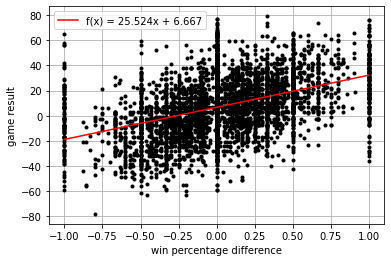

In [14]:
x = np.linspace(-1, 1, 500)
y = baseline_model.coef_ * x + baseline_model.intercept_
y = baseline_model.predict(x.reshape(-1, 1))

plt.xlabel('win percentage difference')
plt.ylabel('game result')
plt.plot(train_in, train_out, '.', color='black')
plt.plot(x, y, '-r', label="f(x) = %.3fx + %.3f" % (baseline_model.coef_, baseline_model.intercept_))
plt.xlim(-1.1, 1.1)
plt.legend()
plt.grid()

prediction = baseline_model.predict(test_in.reshape(-1, 1))
print('Spread RMSE = %.2f points' % mean_squared_error(test_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = test_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

# More Complex Models<a name="complex-models"></a>

## Linear model with more features<a name="linear-complex"></a>

In [15]:
train, valid, test = split_data(start_year=2013)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
test_in = test.drop(columns=['result'])
test_out = test.result

In [16]:
model = LinearRegression().fit(train_in, train_out)
prediction = model.predict(test_in)
print('Spread RMSE = %.2f points' % mean_squared_error(test_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = test_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

Spread RMSE = 16.58 points
Game winner accuracy = 77.123%


## Linear model with L1 Regularization<a name="l1"></a>

In [17]:
alphas = np.linspace(0,2,100)
kf = KFold(n_splits=10, shuffle=True, random_state=42)
mse_valid = []
mse_train = []
num_nonzero = []

for alpha in alphas:
    large_model_lasso = Lasso(alpha=alpha, random_state=77)
    mse_kfold = []
    # Iterate through all folds
    for train_index, test_index in kf.split(train_in):        
        large_model_lasso.fit(train_in.iloc[train_index], train_out.iloc[train_index])
        kf_test_pred = large_model_lasso.predict(train_in.iloc[test_index])
        error = mean_squared_error(train_out.iloc[test_index], kf_test_pred, squared=False)
        mse_kfold.append(error)

    # count number of nonzero coefficients
    num_nonzero.append(np.sum(large_model_lasso.coef_ != 0))
    
    # create error arrays
    mse_train.append(np.mean(mse_kfold))
    large_model_lasso.fit(train_in, train_out)
    pred_valid = large_model_lasso.predict(valid_in)
    mse_valid.append(mean_squared_error(valid_out, pred_valid, squared=False))

Optimum Alpha at 0.51
Optimum Alpha Validation RMSE: 18.68 points


(17.5, 20.0)

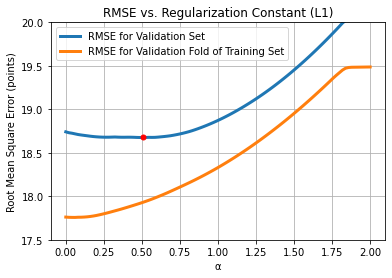

In [18]:
best_alpha = alphas[np.argmin(mse_valid)]
print('Optimum Alpha at %.2f' % best_alpha)
print('Optimum Alpha Validation RMSE: %.2f points' % np.min(mse_valid))

plt.plot(alphas,mse_valid, linewidth=3)
plt.plot(alphas,mse_train, linewidth=3)
plt.plot(best_alpha,np.min(mse_valid),'r.',markersize=10)

plt.legend(['RMSE for Validation Set','RMSE for Validation Fold of Training Set'])
plt.xlabel('α')
plt.ylabel('Root Mean Square Error (points)')
plt.title('RMSE vs. Regularization Constant (L1)')
plt.grid()
plt.ylim([17.5, 20])

In [19]:
lasso_model = Lasso(alpha=best_alpha, random_state=77)
lasso_model.fit(train_in, train_out)
prediction = lasso_model.predict(test_in)
print('Spread RMSE = %.2f points' % mean_squared_error(test_out, prediction, squared=False))

temp_pred = prediction
temp_pred[temp_pred>0] = 1
temp_pred[temp_pred<0] = 0

temp_tru = test_out
temp_tru[temp_tru>0] = 1
temp_tru[temp_tru<0] = 0

print('Game winner accuracy = %.3f%%' % ((np.sum(temp_pred==temp_tru) / len(temp_tru))*100.0))

Spread RMSE = 15.59 points
Game winner accuracy = 77.830%


## Random Forest<a name="random-forest"></a>

In [47]:
train, valid, test = split_data(start_year=2013)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
test_in = test.drop(columns=['result'])
test_out = test.result

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

test_out_winner = test_out
test_out_winner[test_out_winner>0] = 1
test_out_winner[test_out_winner<0] = 0

In [48]:
best_depth = 0
best_acc = 0
for depth in range(1, 30, 2):
  random_model = RandomForestClassifier(max_depth=depth, random_state=0)
  random_model.fit(train_in, train_out_winner)
  acc = (np.sum(random_model.predict(valid_in)==valid_out_winner) / len(valid_out_winner))*100.0
  print('Max Depth: %d \t Accuracy: %.2f' % (depth, acc))
  if acc > best_acc:
    best_acc = acc
    best_depth = depth
  
print('Best Max Depth: %d' % best_depth)

Max Depth: 1 	 Accuracy: 71.38
Max Depth: 3 	 Accuracy: 73.68
Max Depth: 5 	 Accuracy: 74.71
Max Depth: 7 	 Accuracy: 75.06
Max Depth: 9 	 Accuracy: 74.71
Max Depth: 11 	 Accuracy: 74.94
Max Depth: 13 	 Accuracy: 74.37
Max Depth: 15 	 Accuracy: 75.52
Max Depth: 17 	 Accuracy: 75.06
Max Depth: 19 	 Accuracy: 74.14
Max Depth: 21 	 Accuracy: 74.94
Max Depth: 23 	 Accuracy: 75.40
Max Depth: 25 	 Accuracy: 74.71
Max Depth: 27 	 Accuracy: 75.17
Max Depth: 29 	 Accuracy: 75.06
Best Max Depth: 15


Overall game winner accuracy = 78.420%


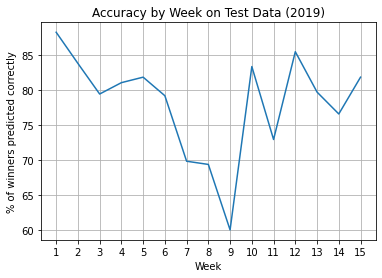

In [49]:
MAX_DEPTH = 15
random_model = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=0)
random_model.fit(train_in, train_out_winner)

acc = []
for week in range(1, 16):
  t = test.loc[(test.week == week)]
  t_in = t.drop(columns=['result'])
  t_out = t.result
  t_out[t_out>0] = 1
  t_out[t_out<0] = 0
  acc.append((np.sum(random_model.predict(t_in)==t_out) / len(t_out))*100.0)

#Line Plot

plt.plot(range(1, 16), acc)
plt.xlabel('Week')
plt.ylabel('% of winners predicted correctly')
plt.title('Accuracy by Week on Test Data (2019)')
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.grid()

# Bar Plot
'''
ax = sns.barplot(x=np.arange(1,16), y=acc, color='b')
plt.xlabel('Week')
plt.ylabel('% of winners predicted correctly')
plt.title('Accuracy by Week on Test Data (2019)')
'''
print('Overall game winner accuracy = %.3f%%' % ((np.sum(random_model.predict(test_in)==test_out_winner) / len(test_out_winner))*100.0))

Our model does better as weeks progress. <br>
The reason accuracy is really high the first few weeks is because the first 3-4 weeks of every college football season is full of out-of-conference games where really good teams play really bad teams and it's often easy to predict the outcome because of that.<br>
As in-conference games start around week 4, our model accuracy goes down. Since those games are with teams of closer strengths.

## Random Forest for Beating Vegas

In [50]:
# Get spread winner output
train, valid, test = split_data(start_year=2013, keep_spread=True)

train_in = train.drop(columns=['result'])
train_out_winner = train.result - train.spread
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_in = valid.drop(columns=['result'])
valid_out_winner = valid.result - valid.spread
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

test_in = test.drop(columns=['result'])
test_out_winner = test.result - test.spread
test_out_winner[test_out_winner>0] = 1
test_out_winner[test_out_winner<0] = 0

In [51]:
best_depth = 0
best_acc = 0
for depth in range(1, 30, 2):
  random_model = RandomForestClassifier(max_depth=depth, random_state=0)
  random_model.fit(train_in, train_out_winner)
  acc = (np.sum(random_model.predict(valid_in)==valid_out_winner) / len(valid_out_winner))*100.0
  print('Max Depth: %d \t Accuracy: %.2f' % (depth, acc))
  if acc > best_acc:
    best_acc = acc
    best_depth = depth
  
print('Best Max Depth: %d' % best_depth)

Max Depth: 1 	 Accuracy: 55.40
Max Depth: 3 	 Accuracy: 54.94
Max Depth: 5 	 Accuracy: 53.10
Max Depth: 7 	 Accuracy: 55.75
Max Depth: 9 	 Accuracy: 52.53
Max Depth: 11 	 Accuracy: 50.69
Max Depth: 13 	 Accuracy: 52.07
Max Depth: 15 	 Accuracy: 51.15
Max Depth: 17 	 Accuracy: 50.57
Max Depth: 19 	 Accuracy: 54.48
Max Depth: 21 	 Accuracy: 52.87
Max Depth: 23 	 Accuracy: 53.33
Max Depth: 25 	 Accuracy: 53.22
Max Depth: 27 	 Accuracy: 53.45
Max Depth: 29 	 Accuracy: 54.60
Best Max Depth: 7


Overall game winner accuracy = 51.769%


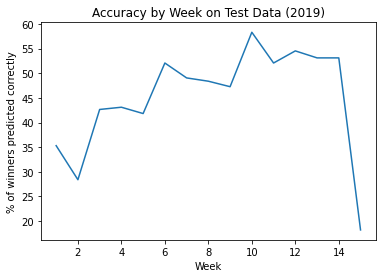

In [52]:
MAX_DEPTH = 7
random_model = RandomForestClassifier(max_depth=MAX_DEPTH, random_state=0)
random_model.fit(train_in, train_out_winner)

acc = []
for week in range(1, 16):
  t = test.loc[(test.week == week)]
  t_in = t.drop(columns=['result'])
  t_out = t.result
  t_out[t_out>0] = 1
  t_out[t_out<0] = 0
  acc.append((np.sum(random_model.predict(t_in)==t_out) / len(t_out))*100.0)

plt.plot(range(1, 16), acc)
plt.xlabel('Week')
plt.ylabel('% of winners predicted correctly')
plt.title('Accuracy by Week on Test Data (2019)')

print('Overall game winner accuracy = %.3f%%' % ((np.sum(random_model.predict(test_in)==test_out_winner) / len(test_out_winner))*100.0))

# Neural Networks<a name="nn"></a>

## Neural Net for Predicting the Spread<a name="spread-regression-nn"></a>

In [26]:
# Hyperparameters
BATCH_SIZE = 800
EPOCHS = 100
LEARNING_RATE = 0.023

In [27]:
# Setup the data
train, valid, test = split_data(start_year=2013)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result
test_in = test.drop(columns=['result'])
test_out = test.result

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out.to_numpy().reshape(-1, 1), dtype=torch.float, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out.to_numpy().reshape(-1, 1), dtype=torch.float, device=device)
data_valid = TensorDataset(data_valid_vals, data_valid_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

data_test_vals = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
data_test_labels = torch.tensor(test_out.to_numpy().reshape(-1, 1), dtype=torch.float, device=device)
data_test = TensorDataset(data_test_vals, data_test_labels)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

In [28]:
def train(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if verbose and epoch % 10 == 0:
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def test(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
  return np.sqrt(test_loss/len(test_loader))

In [29]:
class Net(nn.Module):
  def __init__(self, input_size):
    super(Net, self).__init__()
    if gpu:
      self.fc1 = nn.Linear(input_size, 20).cuda()
      self.fc2 = nn.Linear(20, 10).cuda()
      self.fc3 = nn.Linear(10, 1).cuda()
    else:
      self.fc1 = nn.Linear(input_size, 20)
      self.fc2 = nn.Linear(20, 10)
      self.fc3 = nn.Linear(10, 1)

  def forward(self, x):
    x = F.leaky_relu(self.fc1(x))
    x = F.leaky_relu(self.fc2(x))
    x = self.fc3(x)
    return x

modelSpread = Net(np.shape(train_in.to_numpy())[1])

In [30]:
best_lr = 0
best_loss = 50
epochs = 50
criterion = nn.MSELoss()
for i in range(1, 25):
  lr = 0.001*i
  model = Net(np.shape(train_in.to_numpy())[1])
  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  train(model, device, train_loader, optimizer, epochs, criterion)
  loss = test(model, device, valid_loader, criterion)
  print('LR: %.3f \t Loss: %.2f' % (lr, loss))
  if loss < best_loss:
    best_loss = loss
    best_lr = lr

print('Best LR: %.3f with best loss: %.2f' %(best_lr, best_loss))

LR: 0.001 	 Loss: 20.04
LR: 0.002 	 Loss: 19.71
LR: 0.003 	 Loss: 20.21
LR: 0.004 	 Loss: 19.60
LR: 0.005 	 Loss: 19.47
LR: 0.006 	 Loss: 19.34
LR: 0.007 	 Loss: 19.34
LR: 0.008 	 Loss: 19.34
LR: 0.009 	 Loss: 19.25
LR: 0.010 	 Loss: 19.33
LR: 0.011 	 Loss: 19.06
LR: 0.012 	 Loss: 19.81
LR: 0.013 	 Loss: 19.52
LR: 0.014 	 Loss: 19.43
LR: 0.015 	 Loss: 19.14
LR: 0.016 	 Loss: 19.41
LR: 0.017 	 Loss: 18.81
LR: 0.018 	 Loss: 19.53
LR: 0.019 	 Loss: 18.95
LR: 0.020 	 Loss: 18.83
LR: 0.021 	 Loss: 18.81
LR: 0.022 	 Loss: 18.95
LR: 0.023 	 Loss: 20.03
LR: 0.024 	 Loss: 18.96
Best LR: 0.021 with best loss: 18.81


In [31]:
optimizer = torch.optim.Adam(modelSpread.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

In [32]:
train(modelSpread, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

Train Epoch: 0  	Loss: 23.142118
Train Epoch: 10  	Loss: 18.759810
Train Epoch: 20  	Loss: 18.149095
Train Epoch: 30  	Loss: 18.149829
Train Epoch: 40  	Loss: 17.669174
Train Epoch: 50  	Loss: 17.558990
Train Epoch: 60  	Loss: 17.364934
Train Epoch: 70  	Loss: 17.210003
Train Epoch: 80  	Loss: 17.125645
Train Epoch: 90  	Loss: 17.100569


In [33]:
loss = test(modelSpread, device, valid_loader, criterion)
print('Validation set: Average loss: %.2f' % loss)

Validation set: Average loss: 19.71


In [34]:
loss = test(modelSpread, device, test_loader, criterion)
print('Test set: Average loss: %.2f' % loss)

Test set: Average loss: 17.28


In [35]:
first_loop = True
for input, output in valid_loader.dataset:
  if first_loop:
    pred = modelSpread(input)
    result = output
    first_loop = False
  else:
    pred = torch.cat((pred, modelSpread(input)))
    result = torch.cat((result, output))

acc = np.sum(np.sign(result.detach().cpu().numpy()) == np.sign(pred.cpu().detach().numpy()))/len(result)*100
print('Game winner accuracy (validation) = %.3f%%' % acc)

first_loop = True
for input, output in test_loader.dataset:
  if first_loop:
    pred = modelSpread(input)
    result = output
    first_loop = False
  else:
    pred = torch.cat((pred, modelSpread(input)))
    result = torch.cat((result, output))

acc = np.sum(np.sign(result.detach().cpu().numpy()) == np.sign(pred.cpu().detach().numpy()))/len(result)*100
print('Game winner accuracy (test) = %.3f%%' % acc)

Game winner accuracy (validation) = 72.529%
Game winner accuracy (test) = 76.061%


## Neural Net for Predicting the Winner<a name="winner-classifier-nn"></a>

In [36]:
BATCH_SIZE = 800
EPOCHS = 100
LEARNING_RATE = 0.02

In [37]:
train, valid, test = split_data(start_year=2013)

train_in = train.drop(columns=['result'])
train_out = train.result
valid_in = valid.drop(columns=['result'])
valid_out = valid.result

train_out_winner = train_out
train_out_winner[train_out_winner>0] = 1
train_out_winner[train_out_winner<0] = 0

valid_out_winner = valid_out
valid_out_winner[valid_out_winner>0] = 1
valid_out_winner[valid_out_winner<0] = 0

test_out_winner = test_out
test_out_winner[test_out_winner>0] = 1
test_out_winner[test_out_winner<0] = 0

data_train_vals = torch.tensor(train_in.to_numpy(), dtype=torch.float, device=device)
data_train_labels = torch.tensor(train_out_winner.to_numpy(), dtype=torch.long, device=device)
data_train = TensorDataset(data_train_vals, data_train_labels)
train_loader = DataLoader(dataset = data_train, batch_size = BATCH_SIZE, shuffle = True) 

data_valid_vals = torch.tensor(valid_in.to_numpy(), dtype=torch.float, device=device)
data_valid_labels = torch.tensor(valid_out_winner.to_numpy(), dtype=torch.long, device=device)
data_valid = TensorDataset(data_valid_vals, data_valid_labels)
valid_loader = DataLoader(dataset = data_valid, batch_size = BATCH_SIZE,  shuffle = False)

data_test_vals = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
data_test_labels = torch.tensor(test_out_winner.to_numpy(), dtype=torch.long, device=device)
data_test = TensorDataset(data_test_vals, data_test_labels)
test_loader = DataLoader(dataset = data_test, batch_size = BATCH_SIZE,  shuffle = False)

In [38]:
def trainWinner(model, device, train_loader, optimizer, epochs, criterion, verbose=False):
  for epoch in range(epochs):
    model.train()
    batch_loss = 0
    for data, label in train_loader:
      data, label = data.to(device), label.to(device)
      optimizer.zero_grad()
      output = model(data)
      loss = criterion(output, label)
      loss.backward()
      optimizer.step()
      batch_loss += loss.item()
    if (verbose) & (epoch % 10 == 0):
      print('Train Epoch: %d  \tLoss: %.6f' % (epoch, np.sqrt(batch_loss/len(train_loader))))

def testWinner(model, device, test_loader, criterion):
  model.eval()
  test_loss = 0
  correct = 0
  wrong = 0
  with torch.no_grad():
    for data, label in test_loader:
      data, label = data.to(device), label.to(device)
      output = model(data)
      test_loss += criterion(output, label).item()
      correct += torch.sum(torch.argmax(output, dim=1) == label)
      wrong += torch.sum(torch.argmax(output, dim=1) != label)
  print('Test set: Average loss: %.4f' % np.sqrt(test_loss/len(test_loader)))
  print('Accuracy: %.3f%%' % (correct*100/(correct+wrong)))

In [39]:
class Net(nn.Module):
    def __init__(self, input_size):
        super(Net, self).__init__()
        if gpu:
          self.fc1 = nn.Linear(input_size, 20).cuda()
          self.fc2 = nn.Linear(20, 10).cuda()
          self.fc3 = nn.Linear(10, 2).cuda()
        else:
          self.fc1 = nn.Linear(input_size, 20)
          self.fc2 = nn.Linear(20, 10)
          self.fc3 = nn.Linear(10, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

modelWinner = Net(np.shape(train_in.to_numpy())[1])

In [40]:
optimizer = torch.optim.Adam(modelWinner.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

In [41]:
trainWinner(modelWinner, device, train_loader, optimizer, EPOCHS, criterion, verbose=True)

Train Epoch: 0  	Loss: 1.016556
Train Epoch: 10  	Loss: 0.751042
Train Epoch: 20  	Loss: 0.732491
Train Epoch: 30  	Loss: 0.720231
Train Epoch: 40  	Loss: 0.712590
Train Epoch: 50  	Loss: 0.703211
Train Epoch: 60  	Loss: 0.703410
Train Epoch: 70  	Loss: 0.703648
Train Epoch: 80  	Loss: 0.697866
Train Epoch: 90  	Loss: 0.686066


In [42]:
testWinner(modelWinner, device, valid_loader, criterion)

Test set: Average loss: 0.7701
Accuracy: 74.598%


In [43]:
testWinner(modelWinner, device, test_loader, criterion)

Test set: Average loss: 0.7324
Accuracy: 74.764%


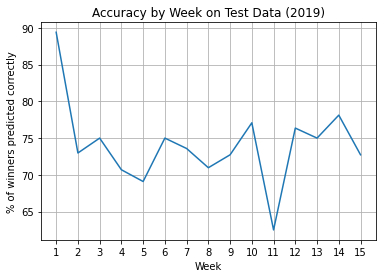

In [44]:
acc = []
for week in range(1, 16):
  t = test.loc[test.week == week]
  t_in = t.drop(columns=['result'])
  t_out = t.result
  t_out[t_out>0] = 1
  t_out[t_out<0] = 0
  tensor_in = torch.tensor(t_in.to_numpy(), dtype=torch.float, device=device)
  output = modelWinner(tensor_in)
  preds = torch.argmax(output, dim=1).detach().cpu().numpy()
  acc.append((np.sum(preds==t_out) / len(t_out))*100.0)
  
plt.plot(range(1, 16), acc)
plt.xlabel('Week')
plt.ylabel('% of winners predicted correctly')
plt.title('Accuracy by Week on Test Data (2019)')
plt.xticks(np.arange(1,16), np.arange(1,16))
plt.grid()

# Compare Best Model to Vegas<a name="compare-vegas"></a>

In [45]:
def predict_betting_wins(pred, spread, result):
  '''
  predict the percent of the time that you beat vegas in betting

  Paramters
  ---------
  prediction : torch.tensor
      vector of predictions of length (N,) where N is number of games
  spread : torch.tensor
      vector of vegas spreads of length (N,) where N is number of games
  result : torch.tensor
      vector of actual game results of length (N,) where N is number of games

  Returns
  -------
  winning_percentage : float
      percent of time that vegas is beat
  '''
  spread_v_pred = torch.sign(pred - spread)
  spread_v_result = torch.sign(result - spread)
  winning_percentage = torch.sum(spread_v_result == spread_v_pred)/result.size()[0]
  return winning_percentage

def calculate_return(winning_percentage):
  return ((winning_percentage * 21/11) - 1) * 100.0

In [46]:
test = games.copy()
test = test.loc[test.season == 2019]
test_in = test.drop(columns=['result', 'season', 'id', 'home_team', 'away_team', 'excitement_index', 'spread'])

# NN spread model
# test_in_tensor = torch.tensor(test_in.to_numpy(), dtype=torch.float, device=device)
# pred = modelSpread(test_in_tensor)
# pred = torch.reshape(pred, (-1,))

# lasso model
# pred = lasso_model.predict(test_in)
# pred = torch.tensor(pred, dtype=torch.float, device=device)

# single feature linear model
pred = baseline_model.predict(test_in.win_difference.to_numpy().reshape(-1, 1))
pred = torch.tensor(pred, dtype=torch.float, device=device)

result = torch.tensor(test.result.to_numpy(), dtype=torch.float, device=device)
vegas = torch.tensor(test.spread.to_numpy(), dtype=torch.float, device=device)
beating_vegas = predict_betting_wins(pred, vegas, result)
print('Percentage of Vegas bets the Test data would\'ve won: %.4f%%' % (beating_vegas * 100.0))
print('Average return on investement betting on the Test Data: %.2f%%' % (calculate_return(beating_vegas)))

Percentage of Vegas bets the Test data would've won: 47.7594%
Average return on investement betting on the Test Data: -8.82%
